In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon
from tqdm.notebook import tqdm
import time
from datetime import datetime

import momepy as mm
import momepy
import networkx as nx

import math

from contextlib import redirect_stdout

import io
import sys

from shapely.ops import nearest_points
from shapely.ops import unary_union

In [ ]:
# проверка остановки в буффере - если даже по вохдуху не попадает - не искать

In [2]:
graph = gpd.read_file('../lines_to_graph/with_ped/new_graph_with_ped.json',
                        encoding='utf-8')

In [3]:
nodes = gpd.read_file('../lines_to_graph/with_ped/all_nodes_with_ped.json',
                        encoding='utf-8')

In [4]:
buildings = gpd.read_file('./all_bui.json',encoding='utf-8')

In [5]:
stps_big = pd.read_csv('../lines_to_graph/total/df_stop_seq_all_n_samobl.csv',
                        encoding='utf-8', sep=';')

In [6]:
stps_big = stps_big[['stop_id', 'stop_name', 'lat', 'lon']]
stps_big = stps_big.drop_duplicates(subset=['stop_id']).reset_index(drop=True)

In [7]:
lst_geo=[]
lst_lat=list(stps_big.lat)
lst_lon=list(stps_big.lon)
i=0
for i in tqdm(range(len(stps_big))):
    one_pt = Point(lst_lon[i], lst_lat[i])
    lst_geo.append(one_pt)
# 

In [8]:
gdf_stops_all = gpd.GeoDataFrame(stps_big, geometry=lst_geo)
gdf_stops_all.crs='epsg:4326'

In [9]:
border_sa = gpd.read_file('./data/outer_border_SA.shp',encoding='utf-8')

In [10]:
gdf_stops = gpd.sjoin(gdf_stops_all, border_sa[['geometry']], how='inner', op='intersects')
gdf_stops = gdf_stops.drop('index_right', axis=1).reset_index(drop=True)

In [11]:
# убрать жд пути из графа
graph_ped = graph[graph.type_ped != 'no_ped'].reset_index(drop=True)[['link_id', 'geometry']]

In [12]:
shrt_bui = buildings[['osm_id', 'geometry']].copy()

In [13]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result
########

In [14]:
def find_closest_stop(gdf_one_bui, gdf_stops, gdf_buff):
    uu_stops = gdf_stops.geometry.unary_union
    centr_bui = gdf_one_bui.geometry[0].centroid
    nrst_pt = nearest_points(centr_bui, uu_stops)[1]
    
    nearest_stop_id = list(gdf_stops[gdf_stops.geometry == nrst_pt]['stop_id'])[0]
    nearest_stop_geo = list(gdf_stops[gdf_stops.geometry == nrst_pt]['geometry'])[0]
    if gdf_buff.geometry[0].intersects(nearest_stop_geo):
        return [nearest_stop_id, nearest_stop_geo]
    else:
        return []

In [15]:
def get_closest_node(gdf_obj, linkid, graph_in_buff):
    line_geo = list(graph_in_buff[graph_in_buff.link_id == linkid]['geometry'])[0]
    start = Point(line_geo.coords[0])
    end = Point(line_geo.coords[-1])
    obj_centr = gdf_obj['geometry'][0]#.centroid

    if start.distance(obj_centr) < end.distance(obj_centr):
        return start
    else:
        return end
# 

In [16]:
def get_shrt_pth(gdf_one_bui, gdf_buff, gdf_stops, graph_ped):

    try:
        nearest_stop = find_closest_stop(gdf_one_bui, gdf_stops, gdf_buff)
    except:
        nearest_stop = []
    #
    if nearest_stop != []:
        gdf_near_stop = gpd.GeoDataFrame(data=[nearest_stop], columns=['stop_id', 'geometry'])
        gdf_near_stop.crs=graph_ped.crs
        graph_in_buff = intersect_using_spatial_index(graph_ped, gdf_buff[['geometry']])
        centr_bui = gdf_one_bui.copy()
        centr_bui.geometry = centr_bui.geometry.centroid

        text_trap = io.StringIO()
        with redirect_stdout(text_trap):
            closest_link_bui = mm.get_network_id(gdf_one_bui, graph_in_buff, 'link_id')[0]
            closest_link_stop = mm.get_network_id(gdf_near_stop, graph_in_buff, 'link_id')[0]

        closest_node_bui = get_closest_node(gdf_one_bui, closest_link_bui, graph_in_buff)
        closest_node_stop = get_closest_node(gdf_near_stop, closest_link_stop, graph_in_buff)

        one_G = mm.gdf_to_nx(graph_in_buff)
        res_lst = nx.shortest_path(one_G, closest_node_bui.coords[0], closest_node_stop.coords[0])

        if len(res_lst) == 1:
            line_path = LineString([closest_node_bui, closest_node_stop])
            path_lngth = 0
        elif len(res_lst) == 0:
            line_path = LineString([closest_node_bui, closest_node_stop])
            path_lngth = -1
        else:
            line_path = LineString(res_lst)
            path_lngth = 1
    # 
        return [nearest_stop[0], path_lngth, res_lst, line_path]
    else:
        return []

In [17]:
def generate_graph(edges, fields):
    G = nx.Graph()

    key = 0
    for index, row in edges.iterrows():
        first = row.from_node
        last = row.to_node

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        G.add_edge(first, last, key=key, **attributes)
        key += 1
    # 
    return G

In [18]:
def get_lst_end_nodes(egg):
    lst_nodes_end=[]
    lst_nodes = list(egg.nodes())
    i=0
    for i in (range(len(lst_nodes))):
        one_node = lst_nodes[i]
        lst_neigh = list(nx.all_neighbors(egg, one_node))
        if len(lst_neigh) < 2:
            lst_nodes_end.append(one_node)
    #
    return lst_nodes_end

In [19]:
def get_strt_end_paths(egg, closest_node, lst_nodes_end):
    
    shortest_paths = list(nx.all_pairs_dijkstra_path(egg, weight='length'))
    
    start_ind=0
    i=0
    for i in range(len(shortest_paths)):
        if shortest_paths[i][0] == closest_node:
            start_ind = i
            break
    # 
    lst_paths_to_ends = []
    i=0
    for nd in shortest_paths[start_ind][1]:
        if nd in lst_nodes_end:
            lst_paths_to_ends.append(shortest_paths[start_ind][1][nd])
    # 
    try:
        lst_paths_to_ends.remove([closest_node])
    except:
        pass
    return lst_paths_to_ends

In [20]:
def find_closest_node(one_stop_gdf, nodes_in_buff):

    stop_pt = one_stop_gdf.geometry[0]
    np_nib = nodes_in_buff.to_numpy()
    ind_ndid = list(nodes_in_buff.columns).index('nodeID')
    ind_geo = list(nodes_in_buff.columns).index('geometry')

    closest_node = np_nib[0, ind_ndid]
    dstnc = 100000000
    i=0
    for i in range(len(np_nib)):
        node_pt = np_nib[i, ind_geo]
        if stop_pt.distance(node_pt) < dstnc:
            dstnc = stop_pt.distance(node_pt)
            closest_node = np_nib[i, ind_ndid]
    # 

    return closest_node

In [52]:
def get_one_stop_graph(one_stop_gdf, nodes, G):
    gdf_buff = one_stop_gdf.copy()
    gdf_buff.geometry = gdf_buff.geometry.to_crs('epsg:32640').buffer(600).to_crs('epsg:4326')
    nodes_in_buff = intersect_using_spatial_index(nodes, gdf_buff[['geometry']]).reset_index(drop=True)

    closest_node = find_closest_node(one_stop_gdf, nodes_in_buff)

    egg = nx.ego_graph(G, closest_node, radius=400, distance='length')
    edglst = nx.to_pandas_edgelist(egg)
    lst_nodes_end = get_lst_end_nodes(egg)
    lst_paths_to_ends = get_strt_end_paths(egg, closest_node, lst_nodes_end)
    return lst_paths_to_ends

In [53]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [160]:
def get_leftovers(np_gnd, ind_frnd, ind_tond, ind_geo, last_id, lns, lst_one, lng_cut):
    left_lines = np_gnd[(
                    ((np_gnd[:,ind_tond] == last_id) & ~(np.isin(np_gnd[:,ind_frnd], lst_one)) 
                     | ((np_gnd[:,ind_frnd] == last_id) & ~(np.isin(np_gnd[:,ind_tond], lst_one))))
                )]
    #

    left_length = lng_cut - lns.length
    lst_leftovers=[]
    i=0
    for i in range(len(left_lines)):
        one_line_left = left_lines[i][ind_geo]
        lst_cut_left = cut(one_line_left, left_length)
        if ((lst_cut_left[0].coords[0] == lns.coords[-1]) 
            | (lst_cut_left[0].coords[-1] == lns.coords[0])):
            cut_left = lst_cut_left[0]
        else:
            try:
                cut_left = lst_cut_left[1]
            except:
                cut_left = lst_cut_left[0]
        #
        lst_leftovers.append(cut_left)
    # 

    return lst_leftovers

In [80]:
def get_one_line(lst_one, np_gnd, ind_frnd, ind_tond, ind_geo):
    lst_geo = []
    i=0
    for i in range(1, len(lst_one)):
        try:
            row = np_gnd[((np_gnd[:,ind_frnd] == lst_one[i-1]) 
                            & (np_gnd[:,ind_tond] == lst_one[i]))][0]
        except:
            row = np_gnd[((np_gnd[:,ind_tond] == lst_one[i-1]) 
                            & (np_gnd[:,ind_frnd] == lst_one[i]))][0]
        #
        geo = row[ind_geo]
        one_line = geo.coords[:]
        if len(lst_geo) > 0:
            if geo.coords[0] != lst_geo[-1]:
                one_line.reverse()
        lst_geo = lst_geo + one_line
    # 

    last_id = lst_one[-1]
    lns = LineString(lst_geo)
    
    return lns

In [212]:
def get_one_end_lines(lst_one, np_gnd, ind_frnd, ind_tond, ind_geo):

    lng_cut = 400

    lns = get_one_line(lst_one, np_gnd, ind_frnd, ind_tond, ind_geo)

    cutted_line, lst_leftovers = check_leftovers(np_gnd, ind_frnd, ind_tond, ind_geo, lns, lst_one, lng_cut)

    lst_lines_one_end = [cutted_line] + lst_leftovers
    
    l1=[]
    i=0
    for i in range(len(lst_one)):
        one_link_lst = lst_one[0:i+1]

        if len(one_link_lst) > 1:
            one_line = get_one_line(one_link_lst, np_gnd, ind_frnd, ind_tond, ind_geo)
            l1.append(one_line)
            cutted_line_sm, lst_leftovers_sm = check_leftovers(np_gnd, ind_frnd, ind_tond, ind_geo, one_line, one_link_lst, lng_cut)
            if lst_leftovers_sm != lst_leftovers:
                j=0
                for j in range(len(lst_leftovers_sm)):
                    if lst_leftovers_sm[j] not in lst_lines_one_end2:
                        lst_lines_one_end.append(lst_leftovers_sm[j])
    #

    return lst_lines_one_end

In [213]:
def get_one_stop_sprut(lst_paths_to_ends, np_gnd, ind_frnd, ind_tond, ind_geo):
    lst_all_ends=[]
    i=0
    for i in range(len(lst_paths_to_ends)):
        lst_one = lst_paths_to_ends[i]
        lst_lines_one_end = get_one_end_lines(lst_one, np_gnd, ind_frnd, ind_tond, ind_geo)
        for k in range(len(lst_lines_one_end)):
            if lst_lines_one_end[k] not in lst_all_ends:
                lst_all_ends.append(lst_lines_one_end[k])
#         lst_all_ends = lst_all_ends + lst_lines_one_end
    # 
    sprut_ml_one_stop = MultiLineString(lst_all_ends)
    return sprut_ml_one_stop

In [199]:
def check_leftovers(np_gnd, ind_frnd, ind_tond, ind_geo, lns2, lst_one2, lng_cut):
    
    last_id = lst_one2[-1]
    
    if lns2.length > lng_cut:
        cutted_line = cut(lns2, lng_cut)[0]
        lst_leftovers=[]
    elif lns2.length == lng_cut:
        cutted_line = lns
        lst_leftovers=[]
    else:
        cutted_line = lns2
        lst_leftovers = get_leftovers(np_gnd, ind_frnd, ind_tond, ind_geo, last_id, lns2, lst_one2, lng_cut)
    #
    return cutted_line, lst_leftovers
#

In [25]:
graph_notdir = graph[graph.direction == 'direct'].reset_index(drop=True)
graph_notdir = graph_notdir[['link_id', 'from_node', 'to_node', 'geometry']]

In [26]:
graph_notdir_32640 = graph_notdir.copy()
graph_notdir_32640 = graph_notdir_32640.to_crs('epsg:32640')
graph_notdir_32640['length'] = graph_notdir_32640.geometry.length
fields = list(graph_notdir_32640.columns)

In [168]:
# graph2 = graph[['link_id', 'from_node', 'to_node', 'geometry']].copy()

In [169]:
# graph2_32640 = graph2.copy()
# graph2_32640 = graph2_32640.to_crs('epsg:32640')
# graph2_32640['length'] = graph2_32640.geometry.length
# fields2 = list(graph2_32640.columns)

In [170]:
# %time GG = generate_graph(graph2_32640, fields2)

Wall time: 44.4 s


In [27]:
# https://github.com/martinfleis/momepy/blob/v0.3.0/momepy/utils.py#L117-L156
%time G = generate_graph(graph_notdir_32640, fields)

Wall time: 21.9 s


In [28]:
np_gnd = graph_notdir_32640.to_numpy()
ind_frnd = list(graph_notdir_32640.columns).index('from_node')
ind_tond = list(graph_notdir_32640.columns).index('to_node')
ind_geo = list(graph_notdir_32640.columns).index('geometry')
ind_li = list(graph_notdir_32640.columns).index('link_id')


In [56]:
i=0
for i in range(1):
# for i in range(len(gdf_stops)):
    one_stop_gdf = gdf_stops.iloc[[i]].reset_index(drop=True)
    %time lst_paths_to_ends = get_one_stop_graph(one_stop_gdf, nodes, G)

Wall time: 150 ms


In [214]:
%time sprut_ml_one_stop = get_one_stop_sprut(lst_paths_to_ends, np_gnd, ind_frnd, ind_tond, ind_geo)

Wall time: 3.74 s


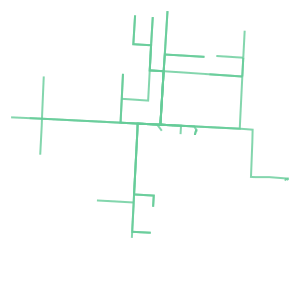

In [215]:
sprut_ml_one_stop

In [216]:
tmp1 = gpd.GeoDataFrame(geometry=list(sprut_ml_one_stop))
tmp1.crs = 'epsg:32640'
tmp1 = tmp1.to_crs('epsg:4326')

In [210]:
tmp1 = gpd.GeoDataFrame(geometry=lst_lines_one_end3)
tmp1.crs = 'epsg:32640'
tmp1 = tmp1.to_crs('epsg:4326')

In [171]:
tmp2 = gpd.GeoDataFrame(geometry=lst_lines_one_end)
tmp2.crs = 'epsg:32640'
tmp2 = tmp2.to_crs('epsg:4326')

In [217]:
tmp1.to_file('tmp1_sprut.json', driver='GeoJSON')
# tmp2.to_file('tmp2_main.json', driver='GeoJSON')